<a href="https://colab.research.google.com/github/olley102/CommunityDetectionURSS/blob/main/clustering_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering image segmentation

Now we have a working autoencoder for a single image, we can apply clustering.

## 1. Setup GDrive and git clone

In [1]:
!git clone https://github.com/olley102/CommunityDetectionURSS.git

Cloning into 'CommunityDetectionURSS'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 186 (delta 84), reused 110 (delta 36), pack-reused 0
Receiving objects: 100% (186/186), 3.62 MiB | 9.12 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [2]:
import sys
sys.path.append('/content/CommunityDetectionURSS')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Load encoding

In [4]:
import numpy as np

In [5]:
encoding = np.load('/content/drive/My Drive/Colab Notebooks/Files/encoding.npy')

In [7]:
encoding.shape

(1796, 1105, 16)

In [8]:
enc = np.reshape(encoding, (-1, 16))

In [9]:
enc.shape

(1984580, 16)

## 3. Clustering

In [ ]:
import matplotlib.pyplot as plt

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(enc)

In [20]:
kmeans_kwargs = dict(init="random", n_init=10, max_iter=10, random_state=42)

In [21]:
sse = []
for k in range(2, 21):
  print(f'Trying {k} clusters')
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features)
  sse.append(kmeans.inertia_)

Trying 2 clusters
Trying 3 clusters
Trying 4 clusters
Trying 5 clusters
Trying 6 clusters
Trying 7 clusters
Trying 8 clusters
Trying 9 clusters
Trying 10 clusters
Trying 11 clusters
Trying 12 clusters
Trying 13 clusters
Trying 14 clusters
Trying 15 clusters
Trying 16 clusters
Trying 17 clusters
Trying 18 clusters
Trying 19 clusters
Trying 20 clusters


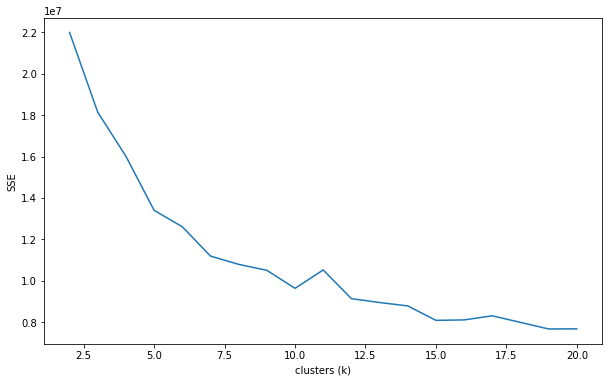

In [33]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
ax.set_xlabel('clusters (k)')
ax.set_ylabel('SSE')
ax.plot(np.arange(2, 21), sse)

In [34]:
kmeans = KMeans(n_clusters=15, **kmeans_kwargs)
kmeans.fit(scaled_features)

KMeans(init='random', max_iter=10, n_clusters=15, random_state=42)

In [36]:
labels = kmeans.labels_.reshape(encoding.shape[:2])

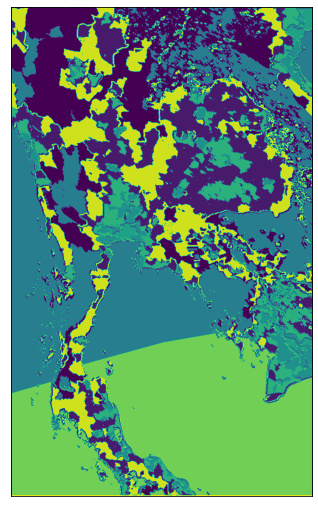

In [40]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.imshow(labels)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.savefig('windowae_cluster_kmeans15')